In [2]:
import os
import numpy as np
import math
import pandas as pd
import json
import sys
import datetime
import traceback
import time

import networkx as nx

import matplotlib.cm as cm
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
from pyspark.sql.types import *

from pyspark.sql.functions import col, log
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf

from aibrain_common.component  import tools
from aibrain_lightgbm.lightgbm import (LightGBMEstimator, LightGBMPredictor)
from aibrain_common.utils.date_convert_utils import DateConvertUtils

import math
import pandas as pd
pd.set_option('mode.chained_assignment', None)

spark = SparkSession.builder.\
        config('spark.executor.memory', '12g').\
        config('spark.executor.cores', '6').\
        config('spark.driver.memory','24g').\
        config('spark.driver.cores','8').\
        config('spark.dynamicAllocation.minExecutors', '8').\
        config('spark.dynamicAllocation.maxExecutors', '32').\
        config("spark.yarn.queue","DataBusinessDept_Risk_Query").\
        config('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2').\
        config('spark.sql.execution.arrow.enabled', 'false').\
        config("spark.hadoop.hive.exec.dynamic.partition", "true").\
        config("spark.hadoop.hive.exec.dynamic.partition.mode", "nonstrict").\
        config('spark.driver.maxResultSize', '32g').\
        config('spark.default.parallelism', '360').\
        config('spark.sql.shuffle.partitions','360').\
        appName('ufa_gateway').\
        enableHiveSupport().getOrCreate()

def quiet_logs(sc):
    logger = sc._jvm.org.apache.log4j
    logger.LogManager.getLogger("org"). setLevel( logger.Level.ERROR )
    logger.LogManager.getLogger("akka").setLevel( logger.Level.ERROR )

quiet_logs(spark)

In [24]:
data_features = spark.sql(f"""
select t1.pt, t1.logtime, t1.seqno, t1.paxjourneyguid, t1.decision
    ,t1.driver_id, t1.driver_mobile, t1.passenger_id, t1.passenger_mobile
    
    ,t1.is_pax_first_order
    ,t1.is_driver_first_order
    ,t1.is_end_changed
    ,t1.is_pindan
    ,t1.is_inner
    ,t1.is_freepay
    ,t1.is_houfu
    ,t1.is_cloud_device
    ,t1.is_public_car
    ,t1.is_pax_is_driver
    ,t1.is_passenger_invitee
    ,t1.is_driver_invitee
    
    ,t1.is_driver_device_simulator
    ,t1.is_driver_device_root
    ,t1.is_driver_ios_debug
    ,t1.is_driver_ios_charging
    ,t1.is_driver_android_multi
    ,t1.is_driver_android_abnormal
    
    ,t1.is_passenger_device_simulator
    ,t1.is_passenger_device_root
    ,t1.is_passenger_ios_debug
    ,t1.is_passenger_ios_charging
    ,t1.is_passenger_android_multi
    ,t1.is_passenger_android_abnormal
    
    ,t1.total_discount
    ,t1.distance
    ,t1.price
    ,t1.realpay
    ,t1.service
    ,t1.profit
    ,t1.orderdtv
    
    ,t1.timediff_systemclose_driverconfirmarrival
    ,t1.timediff_systemclose_paxconfirmarrival
    ,t1.timediff_systemclose_paxconfirmgetoncar
    ,t1.timediff_systemclose_drivergettostart
    ,t1.timediff_systemclose_driveraccept
    ,t1.timediff_systemclose_paxpre
    ,t1.timediff_systemclose_paxplanstart
    ,t1.timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.timediff_driverconfirmarrival_drivergettostart
    ,t1.timediff_driverconfirmarrival_driveraccept
    ,t1.timediff_driverconfirmarrival_paxpre
    ,t1.timediff_driverconfirmarrival_paxplanstart
    ,t1.timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.timediff_paxconfirmarrival_drivergettostart
    ,t1.timediff_paxconfirmarrival_driveraccept
    ,t1.timediff_paxconfirmarrival_paxpre
    ,t1.timediff_paxconfirmarrival_paxplanstart
    ,t1.timediff_paxconfirmgetoncar_drivergettostart
    ,t1.timediff_paxconfirmgetoncar_driveraccept
    ,t1.timediff_paxconfirmgetoncar_paxpre
    ,t1.timediff_paxconfirmgetoncar_paxplanstart
    ,t1.timediff_drivergettostart_driveraccept
    ,t1.timediff_drivergettostart_paxpre
    ,t1.timediff_drivergettostart_paxplanstart
    ,t1.timediff_driveraccept_paxpre
    ,t1.timediff_driveraccept_paxplanstart
    ,t1.timediff_paxplanstart_paxpre
    ,t1.distance_paxpre_orderstart
    ,t1.distance_paxpre_driveraccept
    ,t1.distance_paxpre_drivergettostart
    ,t1.distance_paxpre_paxconfirmgetoncar
    ,t1.distance_paxpre_paxconfirmarrival
    ,t1.distance_paxpre_driverconfirmarrival
    ,t1.distance_paxpre_orderend
    ,t1.distance_driveraccept_orderstart
    ,t1.distance_driveraccept_drivergettostart
    ,t1.distance_driveraccept_paxconfirmgetoncar
    ,t1.distance_driveraccept_paxconfirmarrival
    ,t1.distance_driveraccept_driverconfirmarrival
    ,t1.distance_driveraccept_orderend
    ,t1.distance_drivergettostart_orderstart
    ,t1.distance_drivergettostart_paxconfirmgetoncar
    ,t1.distance_drivergettostart_paxconfirmarrival
    ,t1.distance_drivergettostart_driverconfirmarrival
    ,t1.distance_drivergettostart_orderend
    ,t1.distance_paxconfirmgetoncar_orderstart
    ,t1.distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.distance_paxconfirmgetoncar_orderend
    ,t1.distance_paxconfirmarrival_orderstart
    ,t1.distance_paxconfirmarrival_driverconfirmarrival
    ,t1.distance_paxconfirmarrival_orderend
    ,t1.distance_driverconfirmarrival_orderstart
    ,t1.distance_driverconfirmarrival_orderend
    ,t1.driver_order_speed
    ,t1.pax_order_speed
    ,t1.driveraccept_orderstart_speed
    ,t1.driveraccept_drivergettostart_speed
    ,t1.driveraccept_driverconfirmarrival_speed
    ,t1.driveraccept_orderend_speed
    ,t1.drivergettostart_driverconfirmarrival_speed
    ,t1.drivergettostart_orderend_speed
    ,t1.paxpre_orderstart_speed
    ,t1.paxpre_paxconfirmgetoncar_speed
    ,t1.paxpre_paxconfirmarrival_speed
    ,t1.paxpre_orderend_speed
    ,t1.paxconfirmgetoncar_paxconfirmarrival_speed
    ,t1.paxconfirmgetoncar_orderend_speed
    
    ,t1.pax_remoteip_cnt
    ,t1.pax_remoteip_distinct_cnt
    ,t1.driver_remoteip_cnt
    ,t1.driver_remoteip_distinct_cnt
    ,if(t1.pax_remoteip_cnt = 0, 0 ,1.0000* t1.pax_remoteip_distinct_cnt / t1.pax_remoteip_cnt) as pax_remoteip_distinct_rate
    ,if(t1.driver_remoteip_cnt = 0, 0 ,1.0000* t1.driver_remoteip_distinct_cnt / t1.driver_remoteip_cnt) as driver_remoteip_distinct_rate
    
    ,t1.dpdevicehash_ordcnt
    ,t1.dpdevicehash_reject_ord_cnt
    ,t1.dpdevicehash_posfinishorderdtv_ord_cnt
    ,t1.dpdevicehash_paxpreremote_ord_cnt
    ,t1.dpdevicehash_drivernotarrival_ord_cnt
    ,t1.dpdevicehash_noimcall_ord_cnt
    ,t1.dpdevicehash_norecord_ord_cnt
    ,t1.dpdevicehash_drivernotrace_ord_cnt
    ,t1.dpuid_ordcnt
    ,t1.dpuid_reject_ord_cnt
    ,t1.dpuid_posfinishorderdtv_ord_cnt
    ,t1.dpuid_paxpreremote_ord_cnt
    ,t1.dpuid_drivernotarrival_ord_cnt
    ,t1.dpuid_noimcall_ord_cnt
    ,t1.dpuid_norecord_ord_cnt
    ,t1.dpuid_drivernotrace_ord_cnt
    ,t1.dpmobile_ordcnt
    ,t1.dpmobile_reject_ord_cnt
    ,t1.dpmobile_posfinishorderdtv_ord_cnt
    ,t1.dpmobile_paxpreremote_ord_cnt
    ,t1.dpmobile_drivernotarrival_ord_cnt
    ,t1.dpmobile_noimcall_ord_cnt
    ,t1.dpmobile_norecord_ord_cnt
    ,t1.dpmobile_drivernotrace_ord_cnt
    
    ,t1.driver_no_pax_trace_ord_cnt
    ,t1.driver_no_driver_trace_ord_cnt
    ,t1.driver_no_imcall_ord_cnt
    ,t1.driver_no_record_ord_cnt
    ,t1.pax_no_pax_trace_ord_cnt
    ,t1.pax_no_driver_trace_ord_cnt
    ,t1.pax_no_imcall_ord_cnt
    ,t1.pax_no_record_ord_cnt
    
    ,t1.driveraccept_devicehash_drivercnt
    ,t1.paxpre_devicehash_paxcnt
    ,t1.passenger_openid_paxcnt
    ,t1.paxpre_remoteip_paxcnt
    ,t1.order_shortaddr_paxcnt
    
    ,t1.driver_total_ordcnt
    ,t1.driver_total_paxcnt
    ,t1.driver_discount_ordcnt
    ,t1.driver_discount_paxcnt
    ,t1.driver_paxfirst_ordcnt
    ,1.0000* t1.driver_discount_ordcnt / t1.driver_total_ordcnt as driver_discount_ordrate
    ,1.0000* t1.driver_paxfirst_ordcnt / t1.driver_total_ordcnt as driver_paxfirst_ordrate
    ,1.0000* t1.driver_discount_paxcnt / t1.driver_total_paxcnt as driver_discount_paxrate
    
    ,t1.pax_total_ordcnt
    ,t1.pax_total_drivercnt
    ,t1.pax_discount_ordcnt
    ,t1.pax_discount_drivercnt
    ,t1.pax_driverfirst_ordcnt
    ,1.0000* t1.pax_discount_ordcnt / t1.pax_total_ordcnt as pax_discount_ordrate
    ,1.0000* t1.pax_driverfirst_ordcnt / t1.pax_total_ordcnt as pax_driverfirst_ordrate
    ,1.0000* t1.pax_discount_drivercnt / t1.pax_total_drivercnt as pax_discount_driverrate
    
    ,t1.driver_total_ordcnt_7d
    ,t1.driver_total_paxcnt_7d
    ,t1.driver_discount_ordcnt_7d
    ,t1.driver_discount_paxcnt_7d
    ,t1.driver_paxfirst_ordcnt_7d
    ,1.0000* t1.driver_total_paxcnt_7d / t1.driver_total_ordcnt_7d as driver_pax_avg_ordcnt_7d
    ,1.0000* t1.driver_discount_ordcnt_7d / t1.driver_total_ordcnt_7d as driver_discount_ordrate_7d
    ,1.0000* t1.driver_paxfirst_ordcnt_7d / t1.driver_total_ordcnt_7d as driver_paxfirst_ordrate_7d
    ,1.0000* t1.driver_discount_paxcnt_7d / t1.driver_total_paxcnt_7d as driver_discount_paxrate_7d
    
    ,t1.driver_total_ordcnt_3d
    ,t1.driver_total_paxcnt_3d
    ,t1.driver_discount_ordcnt_3d
    ,t1.driver_discount_paxcnt_3d
    ,t1.driver_paxfirst_ordcnt_3d
    ,1.0000* t1.driver_total_paxcnt_3d / t1.driver_total_ordcnt_3d as driver_pax_avg_ordcnt_3d
    ,1.0000* t1.driver_discount_ordcnt_3d / t1.driver_total_ordcnt_3d as driver_discount_ordrate_3d
    ,1.0000* t1.driver_paxfirst_ordcnt_3d / t1.driver_total_ordcnt_3d as driver_paxfirst_ordrate_3d
    ,1.0000* t1.driver_discount_paxcnt_3d / t1.driver_total_paxcnt_3d as driver_discount_paxrate_3d
    
    ,t1.pax_total_ordcnt_7d
    ,t1.pax_total_drivercnt_7d
    ,t1.pax_discount_ordcnt_7d
    ,t1.pax_discount_drivercnt_7d
    ,t1.pax_driverfirst_ordcnt_7d
    ,1.0000* pax_total_drivercnt_7d / pax_total_ordcnt_7d as pax_driver_avg_ordcnt_7d
    ,1.0000* pax_discount_ordcnt_7d / pax_total_ordcnt_7d as pax_discount_ordrate_7d
    ,1.0000* pax_driverfirst_ordcnt_7d / pax_total_ordcnt_7d as pax_driverfirst_ordrate_7d
    ,1.0000* pax_discount_drivercnt_7d / pax_total_drivercnt_7d as pax_discount_driverrate_7d
    
    ,t1.pax_total_ordcnt_3d
    ,t1.pax_total_drivercnt_3d
    ,t1.pax_discount_ordcnt_3d
    ,t1.pax_discount_drivercnt_3d
    ,t1.pax_driverfirst_ordcnt_3d
    ,1.0000* pax_total_drivercnt_3d / pax_total_ordcnt_3d as pax_driver_avg_ordcnt_3d
    ,1.0000* pax_discount_ordcnt_3d / pax_total_ordcnt_3d as pax_discount_ordrate_3d
    ,1.0000* pax_driverfirst_ordcnt_3d / pax_total_ordcnt_3d as pax_driverfirst_ordrate_3d
    ,1.0000* pax_discount_drivercnt_3d / pax_total_drivercnt_3d as pax_discount_driverrate_3d
    
    ,t1.driveraccept_devicehash_drivercnt_3d
    ,t1.driveraccept_devicehash_drivercnt_7d
    ,t1.paxpre_devicehash_paxcnt_3d
    ,t1.paxpre_devicehash_paxcnt_7d
    ,t1.passenger_openid_paxcnt_3d
    ,t1.passenger_openid_paxcnt_7d
    ,t1.paxpre_remoteip_paxcnt_3d
    ,t1.paxpre_remoteip_paxcnt_7d
    ,t1.order_shortaddr_paxcnt_3d
    ,t1.order_shortaddr_paxcnt_7d
    
    ,t1.journey_im_cnt
    ,t1.journey_call_cnt
    ,t1.journey_record_cnt
    ,t1.pax_point_cnt
    ,t1.driver_point_cnt
    
    ,t1.pax_avg_ordcnt
    ,t1.startgeohash6_avg_ordcnt
    ,t1.endgeohash6_avg_ordcnt
    ,t1.geohash6_avg_ordcnt
    ,t1.startshortaddr_avg_ordcnt
    ,t1.endshortaddr_avg_ordcnt
    ,t1.shortaddr_avg_ordcnt
    ,t1.paxpredevicehash_avg_ordcnt
    ,t1.paxpreremoteip_avg_ordcnt
    ,t1.paxpregeohash_avg_ordcnt
    ,t1.paxopenid_avg_ordcnt
    ,t1.startgeohash6_rate
    ,t1.endgeohash6_rate
    ,t1.geohash6_rate
    ,t1.startshortaddr_rate
    ,t1.endshortaddr_rate
    ,t1.shortaddr_rate
    ,t1.paxpredevicehash_rate
    ,t1.paxpreremoteip_rate
    ,t1.paxpregeohash_rate
    ,t1.paxopenid_rate
    
    ,t1.driver_distance_lastorderend_orderstart
    ,t1.driver_distance_lastorderend_driveraccept
    ,t1.driver_distance_lastorderend_drivergettostart
    ,t1.driver_distance_lastorderend_driverconfirmarrival
    ,t1.driver_distance_lastdriverconfirmarrival_orderstart
    ,t1.driver_time_diff_lastdriverconfirmarrival_driveraccept
    ,t1.driver_time_diff_lastdriverconfirmarrival_drivergettostart
    ,t1.driver_time_diff_lastdriverconfirmarrival_driverconfirmarrival
    ,t1.pax_distance_lastorderend_orderstart
    ,t1.pax_distance_lastorderend_paxpre
    ,t1.pax_distance_lastorderend_paxconfirmgetoncar
    ,t1.pax_distance_lastorderend_paxconfirmarrival
    ,t1.pax_distance_lastpaxconfirmarrival_orderstart
    ,t1.pax_time_diff_lastpaxconfirmarrival_paxconfirmgetoncar
    ,t1.pax_time_diff_lastpaxconfirmarrival_paxconfirmarrival
    
    ,t1.driver_avg_timediff_systemclose_driverconfirmarrival
    ,t1.driver_avg_timediff_systemclose_paxconfirmarrival
    ,t1.driver_avg_timediff_systemclose_paxconfirmgetoncar
    ,t1.driver_avg_timediff_systemclose_drivergettostart
    ,t1.driver_avg_timediff_systemclose_driveraccept
    ,t1.driver_avg_timediff_systemclose_paxpre
    ,t1.driver_avg_timediff_systemclose_paxplanstart
    ,t1.driver_avg_timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.driver_avg_timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.driver_avg_timediff_driverconfirmarrival_drivergettostart
    ,t1.driver_avg_timediff_driverconfirmarrival_driveraccept
    ,t1.driver_avg_timediff_driverconfirmarrival_paxpre
    ,t1.driver_avg_timediff_driverconfirmarrival_paxplanstart
    ,t1.driver_avg_timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.driver_avg_timediff_paxconfirmarrival_drivergettostart
    ,t1.driver_avg_timediff_paxconfirmarrival_driveraccept
    ,t1.driver_avg_timediff_paxconfirmarrival_paxpre
    ,t1.driver_avg_timediff_paxconfirmarrival_paxplanstart
    ,t1.driver_avg_timediff_paxconfirmgetoncar_drivergettostart
    ,t1.driver_avg_timediff_paxconfirmgetoncar_driveraccept
    ,t1.driver_avg_timediff_paxconfirmgetoncar_paxpre
    ,t1.driver_avg_timediff_paxconfirmgetoncar_paxplanstart
    ,t1.driver_avg_timediff_drivergettostart_driveraccept
    ,t1.driver_avg_timediff_drivergettostart_paxpre
    ,t1.driver_avg_timediff_drivergettostart_paxplanstart
    ,t1.driver_avg_timediff_driveraccept_paxpre
    ,t1.driver_avg_timediff_driveraccept_paxplanstart
    ,t1.driver_avg_timediff_paxplanstart_paxpre
    ,t1.driver_avg_distance_paxpre_orderstart
    ,t1.driver_avg_distance_paxpre_driveraccept
    ,t1.driver_avg_distance_paxpre_drivergettostart
    ,t1.driver_avg_distance_paxpre_paxconfirmgetoncar
    ,t1.driver_avg_distance_paxpre_paxconfirmarrival
    ,t1.driver_avg_distance_paxpre_driverconfirmarrival
    ,t1.driver_avg_distance_driveraccept_orderstart
    ,t1.driver_avg_distance_driveraccept_drivergettostart
    ,t1.driver_avg_distance_driveraccept_paxconfirmgetoncar
    ,t1.driver_avg_distance_driveraccept_paxconfirmarrival
    ,t1.driver_avg_distance_driveraccept_driverconfirmarrival
    ,t1.driver_avg_distance_driveraccept_orderend
    ,t1.driver_avg_distance_drivergettostart_orderstart
    ,t1.driver_avg_distance_drivergettostart_paxconfirmgetoncar
    ,t1.driver_avg_distance_drivergettostart_paxconfirmarrival
    ,t1.driver_avg_distance_drivergettostart_driverconfirmarrival
    ,t1.driver_avg_distance_drivergettostart_orderend
    ,t1.driver_avg_distance_paxconfirmgetoncar_orderstart
    ,t1.driver_avg_distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.driver_avg_distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.driver_avg_distance_paxconfirmgetoncar_orderend
    ,t1.driver_avg_distance_paxconfirmarrival_orderstart
    ,t1.driver_avg_distance_paxconfirmarrival_driverconfirmarrival
    ,t1.driver_avg_distance_paxconfirmarrival_orderend
    ,t1.driver_avg_distance_driverconfirmarrival_orderstart
    ,t1.driver_avg_distance_driverconfirmarrival_orderend
    ,t1.driver_avg_speed_paxpre_orderstart
    ,t1.driver_avg_speed_paxpre_paxconfirmgetoncar
    ,t1.driver_avg_speed_driveraccept_orderstart
    ,t1.driver_avg_speed_driveraccept_drivergettostart
    ,t1.driver_avg_speed_paxconfirmgetoncar_paxconfirmarrival
    ,t1.driver_avg_speed_paxconfirmgetoncar_driverconfirmarrival
    ,t1.driver_avg_speed_paxconfirmgetoncar_paxconfirmarrival_theo
    ,t1.driver_avg_speed_paxconfirmgetoncar_driverconfirmarrival_theo
    ,t1.driver_avg_speed_pax_order
    ,t1.driver_avg_speed_driver_order
    ,t1.driver_avg_speed_system_order
    ,t1.pax_avg_timediff_systemclose_driverconfirmarrival
    ,t1.pax_avg_timediff_systemclose_paxconfirmarrival
    ,t1.pax_avg_timediff_systemclose_paxconfirmgetoncar
    ,t1.pax_avg_timediff_systemclose_drivergettostart
    ,t1.pax_avg_timediff_systemclose_driveraccept
    ,t1.pax_avg_timediff_systemclose_paxpre
    ,t1.pax_avg_timediff_systemclose_paxplanstart
    ,t1.pax_avg_timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.pax_avg_timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.pax_avg_timediff_driverconfirmarrival_drivergettostart
    ,t1.pax_avg_timediff_driverconfirmarrival_driveraccept
    ,t1.pax_avg_timediff_driverconfirmarrival_paxpre
    ,t1.pax_avg_timediff_driverconfirmarrival_paxplanstart
    ,t1.pax_avg_timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.pax_avg_timediff_paxconfirmarrival_drivergettostart
    ,t1.pax_avg_timediff_paxconfirmarrival_driveraccept
    ,t1.pax_avg_timediff_paxconfirmarrival_paxpre
    ,t1.pax_avg_timediff_paxconfirmarrival_paxplanstart
    ,t1.pax_avg_timediff_paxconfirmgetoncar_drivergettostart
    ,t1.pax_avg_timediff_paxconfirmgetoncar_driveraccept
    ,t1.pax_avg_timediff_paxconfirmgetoncar_paxpre
    ,t1.pax_avg_timediff_paxconfirmgetoncar_paxplanstart
    ,t1.pax_avg_timediff_drivergettostart_driveraccept
    ,t1.pax_avg_timediff_drivergettostart_paxpre
    ,t1.pax_avg_timediff_drivergettostart_paxplanstart
    ,t1.pax_avg_timediff_driveraccept_paxpre
    ,t1.pax_avg_timediff_driveraccept_paxplanstart
    ,t1.pax_avg_timediff_paxplanstart_paxpre
    ,t1.pax_avg_distance_paxpre_orderstart
    ,t1.pax_avg_distance_paxpre_driveraccept
    ,t1.pax_avg_distance_paxpre_drivergettostart
    ,t1.pax_avg_distance_paxpre_paxconfirmgetoncar
    ,t1.pax_avg_distance_paxpre_paxconfirmarrival
    ,t1.pax_avg_distance_paxpre_driverconfirmarrival
    ,t1.pax_avg_distance_paxpre_orderend
    ,t1.pax_avg_distance_driveraccept_orderstart
    ,t1.pax_avg_distance_driveraccept_drivergettostart
    ,t1.pax_avg_distance_driveraccept_paxconfirmgetoncar
    ,t1.pax_avg_distance_driveraccept_paxconfirmarrival
    ,t1.pax_avg_distance_driveraccept_driverconfirmarrival
    ,t1.pax_avg_distance_driveraccept_orderend
    ,t1.pax_avg_distance_drivergettostart_orderstart
    ,t1.pax_avg_distance_drivergettostart_paxconfirmgetoncar
    ,t1.pax_avg_distance_drivergettostart_paxconfirmarrival
    ,t1.pax_avg_distance_drivergettostart_driverconfirmarrival
    ,t1.pax_avg_distance_drivergettostart_orderend
    ,t1.pax_avg_distance_paxconfirmgetoncar_orderstart
    ,t1.pax_avg_distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.pax_avg_distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.pax_avg_distance_paxconfirmgetoncar_orderend
    ,t1.pax_avg_distance_paxconfirmarrival_orderstart
    ,t1.pax_avg_distance_paxconfirmarrival_driverconfirmarrival
    ,t1.pax_avg_distance_paxconfirmarrival_orderend
    ,t1.pax_avg_distance_driverconfirmarrival_orderstart
    ,t1.pax_avg_distance_driverconfirmarrival_orderend
    ,t1.pax_avg_speed_paxpre_orderstart
    ,t1.pax_avg_speed_paxpre_paxconfirmgetoncar
    ,t1.pax_avg_speed_driveraccept_orderstart
    ,t1.pax_avg_speed_driveraccept_drivergettostart
    ,t1.pax_avg_speed_paxconfirmgetoncar_paxconfirmarrival
    ,t1.pax_avg_speed_paxconfirmgetoncar_driverconfirmarrival
    ,t1.pax_avg_speed_paxconfirmgetoncar_paxconfirmarrival_theo
    ,t1.pax_avg_speed_paxconfirmgetoncar_driverconfirmarrival_theo
    ,t1.pax_avg_speed_pax_order
    ,t1.pax_avg_speed_driver_order
    ,t1.pax_avg_speed_system_order
from ( 
    select *
    from risk.t_hitch_features_v1_total_features
    where pt >= '20230701' and pt <= '20240201'
    and distance < 350000
) as t1
""")

data_features = data_features.drop('hitrules')

total_features = data_features.columns.copy()
for feature in ["pt","logtime","seqno","paxjourneyguid","decision",
                "driver_id","driver_mobile","passenger_id","passenger_mobile"]:
    total_features.remove(feature)
    
data_features = data_features.select("pt","logtime","seqno","paxjourneyguid","decision",
                   "driver_id","driver_mobile","passenger_id","passenger_mobile",
                   (*(col(c).cast("double").alias(c) for c in total_features))).distinct()

#data = data.na.fill(0)

In [25]:
data_label = spark.sql("""
    select
      seq_no,
      handle_result
    from
      risk.risk_risk_sample_mark_result_df ---结果表
    where
      pt >= '20230701' and pt <= '20240201'
      and mark_status = '1' --是否处理
      and is_delete = 'false' --是否已删除
      and substr(handle_time, 1, 10) between '2023-07-01' and '2024-02-01'
""")

In [26]:
data_features = data_features.withColumnRenamed("seqno","seq_no")
data = data_features.join(data_label,on="seq_no").drop_duplicates()

In [27]:
pd_df = data.toPandas()

In [28]:
pd_df.head()

seq_no        pt                  logtime  \
0  JP20230904359583zx002043731778  20230904  2023-09-04 13:02:44.018   
1  JP20230905455348zx002044558094  20230905  2023-09-05 19:55:12.937   
2  JP20230905531001zx002044756837  20230905  2023-09-05 23:48:37.242   
3  JP202309064459830T001309713002  20230906  2023-09-06 15:28:17.291   
4  JP202309064706940T001555354860  20230906  2023-09-06 07:35:44.991   

                   paxjourneyguid decision   driver_id driver_mobile  \
0  JP20230904359583zx002043731778   ACCEPT  1534145673   13266327350   
1  JP20230905455348zx002044558094   ACCEPT  1931122364   16710148119   
2  JP20230905531001zx002044756837   ACCEPT  2017968416   13383198292   
3  JP202309064459830T001309713002   REJECT  2012068826   13536948208   
4  JP202309064706940T001555354860   ACCEPT  1353306096   15913874703   

  passenger_id passenger_mobile  is_pax_first_order  is_driver_first_order  \
0   2043731778      14124884284                 1.0                    0.0   
1   2044558094      13840000010                 1.0                    0.0   
2   2044756837      16662834156                 1.0                    0.0   
3   1309713002      13692034923                 0.0                    0.0   
4   1555354860      15917784383                 0.0                    0.0   

   is_end_changed  is_pindan  is_inner  is_freepay  is_houfu  is_cloud_device  \
0             0.0        0.0       1.0         0.0       0.0              0.0   
1             0.0        0.0       0.0         0.0       0.0              0.0   
2             0.0        1.0       1.0         0.0       0.0              0.0   
3             0.0        0.0       1.0         0.0       0.0              0.0   
4             0.0        0.0       1.0         0.0       0.0              0.0   

   is_public_car  is_pax_is_driver  is_passenger_invitee  is_driver_invitee  \
0            0.0               0.0                   0.0                0.0   
1            0.0               0.0                   0.0                0.0   
2            0.0               0.0                   0.0                0.0   
3            0.0               0.0                   0.0                0.0   
4            0.0               0.0                   0.0                0.0   

   is_driver_device_simulator  is_driver_device_root  is_driver_ios_debug  \
0                         0.0                    1.0                  0.0   
1                         0.0                    0.0                  0.0   
2                         0.0                    0.0                  0.0   
3                         0.0                    0.0                  0.0   
4                         0.0                    0.0                  0.0   

   is_driver_ios_charging  is_driver_android_multi  \
0                     0.0                      0.0   
1                     0.0                      0.0   
2                     0.0                      0.0   
3                     0.0                      0.0   
4                     0.0                      0.0   

   is_driver_android_abnormal  is_passenger_device_simulator  \
0                         0.0                            0.0   
1                         0.0                            0.0   
2                         0.0                            0.0   
3                         0.0                            0.0   
4                         0.0                            0.0   

   is_passenger_device_root  is_passenger_ios_debug  \
0                       0.0                     0.0   
1                       0.0                     0.0   
2                       0.0                     0.0   
3                       0.0                     0.0   
4                       0.0                     0.0   

   is_passenger_ios_charging  is_passenger_android_multi  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                  

### 特征工程

In [29]:
pd_df_2 = pd_df[pd_df["decision"] == "ACCEPT"].reset_index(drop=True)

In [30]:
# 替换数值并查看数量
pd_df_2['handle_result'] = pd_df_2['handle_result'].replace({'有风险': 1, '无风险': 0})
pd_df_2 = pd_df_2[pd_df_2['handle_result'] != '风险待定']
value_counts = pd_df_2['handle_result'].value_counts()

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [31]:
pd_df_2 = pd_df_2.drop("paxjourneyguid",axis=1)

In [32]:
# 将 "logtime" 列转换为 datetime 类型
pd_df_2['logtime'] = pd.to_datetime(pd_df_2['logtime'])

# 从 "logtime" 中提取小时
pd_df_2['hour'] = pd_df_2['logtime'].dt.hour

# 根据星期几创建 one-hot 特征
pd_df_2['weekday'] = pd_df_2['logtime'].dt.dayofweek

In [33]:
basic_columns = ["seq_no","pt","logtime","decision","driver_id","driver_mobile","passenger_id","passenger_mobile"]
label = ["handle_result"]
# top_columns = ['distance_driveraccept_orderstart', 'driver_point_cnt', 'timediff_systemclose_paxconfirmgetoncar', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_paxconfirmgetoncar_driveraccept', 'distance_driveraccept_orderend', 'realpay', 'timediff_driveraccept_paxpre', 'profit', 'pax_point_cnt', 'timediff_paxconfirmgetoncar_paxpre', 'distance_paxconfirmgetoncar_orderend', 'weekday', 'distance_paxpre_orderend', 'driver_total_ordcnt_7d', 'distance', 'driver_order_speed', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre', 'driver_total_paxcnt_7d', 'driver_total_ordcnt_3d', 'driver_discount_ordcnt_7d', 'driver_pax_avg_ordcnt_7d', 'driver_discount_ordrate_7d', 'driver_paxfirst_ordcnt_7d', 'paxpre_remoteip_paxcnt', 'driver_paxfirst_ordrate_3d', 'driver_discount_ordcnt', 'driver_discount_ordcnt_3d', 'driver_total_ordcnt', 'driver_pax_avg_ordcnt_3d', 'driver_paxfirst_ordcnt_3d', 'is_pax_first_order', 'driver_total_paxcnt_3d', 'pax_remoteip_cnt', 'driver_paxfirst_ordcnt', 'is_driver_first_order', 'driver_discount_ordrate_3d', 'is_pindan', 'driver_discount_paxcnt_7d', 'is_passenger_invitee', 'is_driver_device_root', 'driver_discount_paxrate_7d']
top_columns = ['distance_driveraccept_orderstart', 'driver_point_cnt', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_systemclose_paxconfirmgetoncar', 'profit', 'distance_driveraccept_orderend', 'timediff_paxconfirmgetoncar_driveraccept', 'realpay', 'timediff_driveraccept_paxpre', 'distance_paxconfirmgetoncar_orderend', 'timediff_paxconfirmgetoncar_paxpre', 'weekday', 'pax_point_cnt', 'distance_paxpre_orderend', 'driver_order_speed', 'driver_total_ordcnt_7d', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre']

In [34]:
# # 计算 handle_result 列中 0 和 1 的数量
# value_counts = pd_df_2['handle_result'].value_counts()
# print(value_counts)

In [35]:
# 统计0的数量
count_0 = len(pd_df_2[pd_df_2['handle_result'] == 0])
count_1 = len(pd_df_2[pd_df_2['handle_result'] == 1])
sampled_df_0 = pd_df_2[pd_df_2['handle_result'] == 0].sample(count_1 * 2, replace=False, random_state=1)
sampled_df = pd.concat([sampled_df_0, pd_df_2[pd_df_2['handle_result'] == 1]]).reset_index(drop=True)

In [36]:
sampled_df['handle_result'].value_counts()

0    4816
1    2408
Name: handle_result, dtype: int64

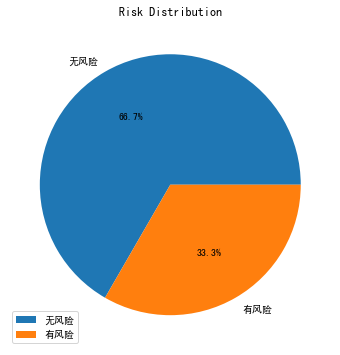

In [37]:
# 计算 handle_result 列中 0 和 1 的数量
value_counts = sampled_df['handle_result'].value_counts()

# 调整图尺寸
fig, ax = plt.subplots(figsize=(6, 6))

# 画饼图
labels = ['无风险','有风险']
ax.pie(value_counts, labels=labels, autopct='%1.1f%%')

# 添加标题
ax.set_title('Risk Distribution')

# 显示图例
ax.legend()

In [38]:
sampled_df

seq_no        pt                 logtime  \
0     JP202310097742180T001329497013  20231009 2023-10-09 17:39:52.974   
1     JP202310127495090W001507196231  20231012 2023-10-12 10:56:16.944   
2     JP202309135628210J001800607415  20230913 2023-09-13 23:58:12.850   
3     JP202310258715280O001429351226  20231025 2023-10-25 01:18:46.948   
4     JP202311120564130C002098183728  20231112 2023-11-12 17:41:22.289   
...                              ...       ...                     ...   
7219  JP202312213955550T001203968986  20231221 2023-12-21 16:58:04.689   
7220  JP20230906533997zx002045095361  20230906 2023-09-06 15:44:32.330   
7221  JP202309115597440J001600982448  20230911 2023-09-11 20:59:26.382   
7222  JP202312224408260S001690302075  20231222 2023-12-22 13:58:12.025   
7223  JP202312253615970J001305488138  20231225 2023-12-25 18:00:28.752   

     decision   driver_id driver_mobile passenger_id passenger_mobile  \
0      ACCEPT  1574747470   18507639858   1329497013      15817947450   
1      ACCEPT  1355397259   13587787740   1507196231      17625647210   
2      ACCEPT  1274598628   13562910341   1800607415      19954445547   
3      ACCEPT  1025014253   18975137884   1429351226      13308448339   
4      ACCEPT  1266489737   13485692934   2098183728      18100508633   
...       ...         ...           ...          ...              ...   
7219   ACCEPT  1778273827   19928410993   1203968986      13129242008   
7220   ACCEPT  1434404543   13652880159   2045095361      16644978540   
7221   ACCEPT  1915163456   18632024664   1600982448      15103102337   
7222   ACCEPT  1668163392   13987608076   1690302075      15987801024   
7223   ACCEPT  2043042467   15664473338   1305488138      15065313388   

      is_pax_first_order  is_driver_first_order  is_end_changed  is_pindan  \
0                    0.0                    0.0             0.0        0.0   
1                    0.0                    0.0             0.0        0.0   
2                    1.0                    0.0             0.0        0.0   
3                    0.0                    0.0             0.0        1.0   
4                    1.0                    0.0             0.0        0.0   
...                  ...                    ...             ...        ...   
7219                 0.0                    0.0             0.0        0.0   
7220                 1.0                    0.0             0.0        0.0   
7221                 1.0                    0.0             0.0        0.0   
7222                 1.0                    0.0             0.0        0.0   
7223                 1.0                    0.0             0.0        0.0   

      is_inner  is_freepay  is_houfu  is_cloud_device  is_public_car  \
0          1.0         0.0       0.0              0.0            0.0   
1          1.0         0.0       0.0              0.0            0.0   
2          1.0         0.0       0.0              0.0            0.0   
3          1.0         0.0       0.0              0.0            0.0   
4          1.0         0.0       0.0              0.0            0.0   
...        ...         ...       ...              ...            ...   
7219       0.0         0.0       0.0              0.0            0.0   
7220       1.0         0.0       0.0              0.0            0.0   
7221       1.0         0.0       0.0              0.0            0.0   
7222       1.0         0.0       0.0              0.0            0.0   
7223       1.0         0.0       0.0              0.0            0.0   

      is_pax_is_driver  is_passenger_invitee  is_driver_invitee  \
0                  0.0                   0.0                0.0   
1                  0.0                   0.0                0.0   
2                  0.0                   0.0                0.0   
3                  0.0                   0.0                0.0   
4                  0.0                   1.0                0.0   
...                ...                   ...                

### 数据建模

In [39]:
from sklearn.model_selection import train_test_split
# 切分数据集
train_set, test_set = train_test_split(sampled_df, test_size=0.3, random_state=42)

In [40]:
print(len(train_set))
print(len(test_set))

5056
2168


In [41]:
train_set_basic = train_set[basic_columns]
X_train = train_set[top_columns]
y_train = train_set[label]

In [42]:
test_set_basic = test_set[basic_columns]
X_test = test_set[top_columns]
y_test = test_set[label]

In [43]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [44]:
# 将 y 从 DataFrame 转换为一维数组
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [45]:
# 输出最佳的超参数组合
import xgboost as xgb
from sklearn.metrics import accuracy_score

best_model = xgb.XGBClassifier(max_depth=8,n_estimators=300)
# 使用最佳的超参数组合重新拟合模型
# best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# 在训练集上评估模型性能
y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", train_accuracy)

# 在测试集上评估模型性能
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.9312730627306273


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
import pickle
# 将模型保存到文件
filename = 'hitch_false_order_identification_v1.pkl'
pickle.dump(best_model, open(filename, 'wb'))

### 模型结果测试集可视化

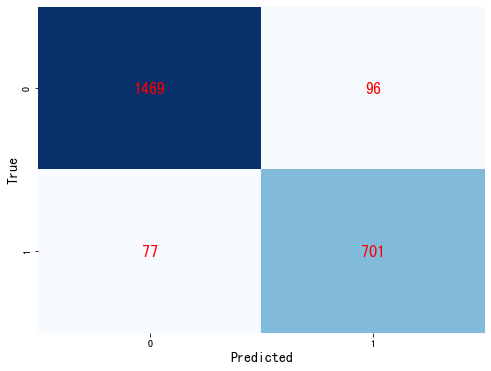

In [31]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

# 获取坐标轴对象
plt.gca().set_ylim(len(cm), 0)  # 翻转 y 轴，使得顶部为0

# 将数字放置在格子的正中间
for i in range(len(cm)):
    for j in range(len(cm[i])):
        ax.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', fontsize=16,color='red')

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

Feature: distance_driveraccept_orderstart, Importance: 0.06600268930196762
Feature: driver_point_cnt, Importance: 0.06576555222272873
Feature: driver_total_ordcnt_7d, Importance: 0.06489605456590652
Feature: distance_paxpre_orderstart, Importance: 0.06023239344358444
Feature: timediff_systemclose_paxconfirmgetoncar, Importance: 0.050430797040462494
Feature: distance_paxconfirmgetoncar_orderstart, Importance: 0.04900798201560974
Feature: profit, Importance: 0.048928938806056976
Feature: timediff_paxconfirmgetoncar_driveraccept, Importance: 0.04798039793968201
Feature: distance_driveraccept_orderend, Importance: 0.04750612750649452
Feature: realpay, Importance: 0.04568808898329735


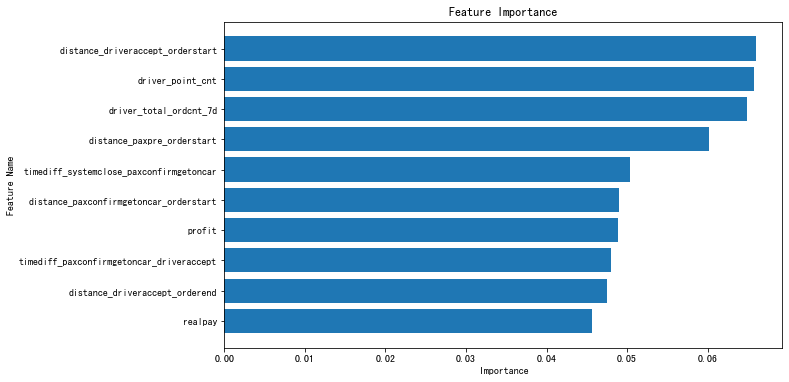

In [32]:
# 获取特征重要性
importances = best_model.feature_importances_

# 获取特征名称
feature_names = X_train.columns  # 如果 X 是一个 pandas DataFrame

indices = np.argsort(importances)[::-1]

# 输出最重要的前10个特征的名称和重要性
top_features = zip(feature_names[indices[:10]], importances[indices[:10]])
for feature, importance in top_features:
    print(f"Feature: {feature}, Importance: {importance}")
    
# 可视化特征重要性（横向）
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(10), importances[indices[:10][::-1]], align="center")  # 使用barh绘制横向条形图
plt.yticks(range(10), feature_names[indices[:10][::-1]])  # 使用yticks设置特征名称
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.show()

In [33]:
y_pred_proba = best_model.predict_proba(X_test)
test_set["y_pred"] = y_pred
test_set["y_pred_proba"] = y_pred_proba[:, -1]

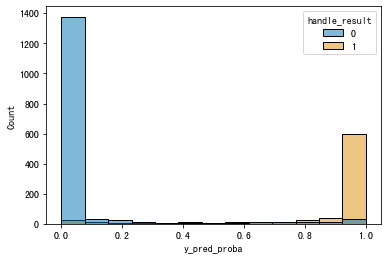

In [34]:
sns.histplot(data=test_set, x="y_pred_proba", hue="handle_result", kde=False, palette="colorblind")

### 线上测试

In [11]:
test_features = spark.sql(f"""
select t1.pt, t1.logtime, t1.seqno, t1.paxjourneyguid
    ,t1.driver_id, t1.driver_mobile, t1.passenger_id, t1.passenger_mobile
    
    ,t1.is_pax_first_order
    ,t1.is_driver_first_order
    ,t1.is_end_changed
    ,t1.is_pindan
    ,t1.is_inner
    ,t1.is_freepay
    ,t1.is_houfu
    ,t1.is_cloud_device
    ,t1.is_public_car
    ,t1.is_pax_is_driver
    ,t1.is_passenger_invitee
    ,t1.is_driver_invitee
    
    ,t1.is_driver_device_simulator
    ,t1.is_driver_device_root
    ,t1.is_driver_ios_debug
    ,t1.is_driver_ios_charging
    ,t1.is_driver_android_multi
    ,t1.is_driver_android_abnormal
    
    ,t1.is_passenger_device_simulator
    ,t1.is_passenger_device_root
    ,t1.is_passenger_ios_debug
    ,t1.is_passenger_ios_charging
    ,t1.is_passenger_android_multi
    ,t1.is_passenger_android_abnormal
    
    ,t1.total_discount
    ,t1.distance
    ,t1.price
    ,t1.realpay
    ,t1.service
    ,t1.profit
    ,t1.orderdtv
    
    ,t1.timediff_systemclose_driverconfirmarrival
    ,t1.timediff_systemclose_paxconfirmarrival
    ,t1.timediff_systemclose_paxconfirmgetoncar
    ,t1.timediff_systemclose_drivergettostart
    ,t1.timediff_systemclose_driveraccept
    ,t1.timediff_systemclose_paxpre
    ,t1.timediff_systemclose_paxplanstart
    ,t1.timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.timediff_driverconfirmarrival_drivergettostart
    ,t1.timediff_driverconfirmarrival_driveraccept
    ,t1.timediff_driverconfirmarrival_paxpre
    ,t1.timediff_driverconfirmarrival_paxplanstart
    ,t1.timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.timediff_paxconfirmarrival_drivergettostart
    ,t1.timediff_paxconfirmarrival_driveraccept
    ,t1.timediff_paxconfirmarrival_paxpre
    ,t1.timediff_paxconfirmarrival_paxplanstart
    ,t1.timediff_paxconfirmgetoncar_drivergettostart
    ,t1.timediff_paxconfirmgetoncar_driveraccept
    ,t1.timediff_paxconfirmgetoncar_paxpre
    ,t1.timediff_paxconfirmgetoncar_paxplanstart
    ,t1.timediff_drivergettostart_driveraccept
    ,t1.timediff_drivergettostart_paxpre
    ,t1.timediff_drivergettostart_paxplanstart
    ,t1.timediff_driveraccept_paxpre
    ,t1.timediff_driveraccept_paxplanstart
    ,t1.timediff_paxplanstart_paxpre
    ,t1.distance_paxpre_orderstart
    ,t1.distance_paxpre_driveraccept
    ,t1.distance_paxpre_drivergettostart
    ,t1.distance_paxpre_paxconfirmgetoncar
    ,t1.distance_paxpre_paxconfirmarrival
    ,t1.distance_paxpre_driverconfirmarrival
    ,t1.distance_paxpre_orderend
    ,t1.distance_driveraccept_orderstart
    ,t1.distance_driveraccept_drivergettostart
    ,t1.distance_driveraccept_paxconfirmgetoncar
    ,t1.distance_driveraccept_paxconfirmarrival
    ,t1.distance_driveraccept_driverconfirmarrival
    ,t1.distance_driveraccept_orderend
    ,t1.distance_drivergettostart_orderstart
    ,t1.distance_drivergettostart_paxconfirmgetoncar
    ,t1.distance_drivergettostart_paxconfirmarrival
    ,t1.distance_drivergettostart_driverconfirmarrival
    ,t1.distance_drivergettostart_orderend
    ,t1.distance_paxconfirmgetoncar_orderstart
    ,t1.distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.distance_paxconfirmgetoncar_orderend
    ,t1.distance_paxconfirmarrival_orderstart
    ,t1.distance_paxconfirmarrival_driverconfirmarrival
    ,t1.distance_paxconfirmarrival_orderend
    ,t1.distance_driverconfirmarrival_orderstart
    ,t1.distance_driverconfirmarrival_orderend
    ,t1.driver_order_speed
    ,t1.pax_order_speed
    ,t1.driveraccept_orderstart_speed
    ,t1.driveraccept_drivergettostart_speed
    ,t1.driveraccept_driverconfirmarrival_speed
    ,t1.driveraccept_orderend_speed
    ,t1.drivergettostart_driverconfirmarrival_speed
    ,t1.drivergettostart_orderend_speed
    ,t1.paxpre_orderstart_speed
    ,t1.paxpre_paxconfirmgetoncar_speed
    ,t1.paxpre_paxconfirmarrival_speed
    ,t1.paxpre_orderend_speed
    ,t1.paxconfirmgetoncar_paxconfirmarrival_speed
    ,t1.paxconfirmgetoncar_orderend_speed
    
    ,t1.pax_remoteip_cnt
    ,t1.pax_remoteip_distinct_cnt
    ,t1.driver_remoteip_cnt
    ,t1.driver_remoteip_distinct_cnt
    ,if(t1.pax_remoteip_cnt = 0, 0 ,1.0000* t1.pax_remoteip_distinct_cnt / t1.pax_remoteip_cnt) as pax_remoteip_distinct_rate
    ,if(t1.driver_remoteip_cnt = 0, 0 ,1.0000* t1.driver_remoteip_distinct_cnt / t1.driver_remoteip_cnt) as driver_remoteip_distinct_rate
    
    ,t1.dpdevicehash_ordcnt
    ,t1.dpdevicehash_reject_ord_cnt
    ,t1.dpdevicehash_posfinishorderdtv_ord_cnt
    ,t1.dpdevicehash_paxpreremote_ord_cnt
    ,t1.dpdevicehash_drivernotarrival_ord_cnt
    ,t1.dpdevicehash_noimcall_ord_cnt
    ,t1.dpdevicehash_norecord_ord_cnt
    ,t1.dpdevicehash_drivernotrace_ord_cnt
    ,t1.dpuid_ordcnt
    ,t1.dpuid_reject_ord_cnt
    ,t1.dpuid_posfinishorderdtv_ord_cnt
    ,t1.dpuid_paxpreremote_ord_cnt
    ,t1.dpuid_drivernotarrival_ord_cnt
    ,t1.dpuid_noimcall_ord_cnt
    ,t1.dpuid_norecord_ord_cnt
    ,t1.dpuid_drivernotrace_ord_cnt
    ,t1.dpmobile_ordcnt
    ,t1.dpmobile_reject_ord_cnt
    ,t1.dpmobile_posfinishorderdtv_ord_cnt
    ,t1.dpmobile_paxpreremote_ord_cnt
    ,t1.dpmobile_drivernotarrival_ord_cnt
    ,t1.dpmobile_noimcall_ord_cnt
    ,t1.dpmobile_norecord_ord_cnt
    ,t1.dpmobile_drivernotrace_ord_cnt
    
    ,t1.driver_no_pax_trace_ord_cnt
    ,t1.driver_no_driver_trace_ord_cnt
    ,t1.driver_no_imcall_ord_cnt
    ,t1.driver_no_record_ord_cnt
    ,t1.pax_no_pax_trace_ord_cnt
    ,t1.pax_no_driver_trace_ord_cnt
    ,t1.pax_no_imcall_ord_cnt
    ,t1.pax_no_record_ord_cnt
    
    ,t1.driveraccept_devicehash_drivercnt
    ,t1.paxpre_devicehash_paxcnt
    ,t1.passenger_openid_paxcnt
    ,t1.paxpre_remoteip_paxcnt
    ,t1.order_shortaddr_paxcnt
    
    ,t1.driver_total_ordcnt
    ,t1.driver_total_paxcnt
    ,t1.driver_discount_ordcnt
    ,t1.driver_discount_paxcnt
    ,t1.driver_paxfirst_ordcnt
    ,1.0000* t1.driver_discount_ordcnt / t1.driver_total_ordcnt as driver_discount_ordrate
    ,1.0000* t1.driver_paxfirst_ordcnt / t1.driver_total_ordcnt as driver_paxfirst_ordrate
    ,1.0000* t1.driver_discount_paxcnt / t1.driver_total_paxcnt as driver_discount_paxrate
    
    ,t1.pax_total_ordcnt
    ,t1.pax_total_drivercnt
    ,t1.pax_discount_ordcnt
    ,t1.pax_discount_drivercnt
    ,t1.pax_driverfirst_ordcnt
    ,1.0000* t1.pax_discount_ordcnt / t1.pax_total_ordcnt as pax_discount_ordrate
    ,1.0000* t1.pax_driverfirst_ordcnt / t1.pax_total_ordcnt as pax_driverfirst_ordrate
    ,1.0000* t1.pax_discount_drivercnt / t1.pax_total_drivercnt as pax_discount_driverrate
    
    ,t1.driver_total_ordcnt_7d
    ,t1.driver_total_paxcnt_7d
    ,t1.driver_discount_ordcnt_7d
    ,t1.driver_discount_paxcnt_7d
    ,t1.driver_paxfirst_ordcnt_7d
    ,1.0000* t1.driver_total_paxcnt_7d / t1.driver_total_ordcnt_7d as driver_pax_avg_ordcnt_7d
    ,1.0000* t1.driver_discount_ordcnt_7d / t1.driver_total_ordcnt_7d as driver_discount_ordrate_7d
    ,1.0000* t1.driver_paxfirst_ordcnt_7d / t1.driver_total_ordcnt_7d as driver_paxfirst_ordrate_7d
    ,1.0000* t1.driver_discount_paxcnt_7d / t1.driver_total_paxcnt_7d as driver_discount_paxrate_7d
    
    ,t1.driver_total_ordcnt_3d
    ,t1.driver_total_paxcnt_3d
    ,t1.driver_discount_ordcnt_3d
    ,t1.driver_discount_paxcnt_3d
    ,t1.driver_paxfirst_ordcnt_3d
    ,1.0000* t1.driver_total_paxcnt_3d / t1.driver_total_ordcnt_3d as driver_pax_avg_ordcnt_3d
    ,1.0000* t1.driver_discount_ordcnt_3d / t1.driver_total_ordcnt_3d as driver_discount_ordrate_3d
    ,1.0000* t1.driver_paxfirst_ordcnt_3d / t1.driver_total_ordcnt_3d as driver_paxfirst_ordrate_3d
    ,1.0000* t1.driver_discount_paxcnt_3d / t1.driver_total_paxcnt_3d as driver_discount_paxrate_3d
    
    ,t1.pax_total_ordcnt_7d
    ,t1.pax_total_drivercnt_7d
    ,t1.pax_discount_ordcnt_7d
    ,t1.pax_discount_drivercnt_7d
    ,t1.pax_driverfirst_ordcnt_7d
    ,1.0000* pax_total_drivercnt_7d / pax_total_ordcnt_7d as pax_driver_avg_ordcnt_7d
    ,1.0000* pax_discount_ordcnt_7d / pax_total_ordcnt_7d as pax_discount_ordrate_7d
    ,1.0000* pax_driverfirst_ordcnt_7d / pax_total_ordcnt_7d as pax_driverfirst_ordrate_7d
    ,1.0000* pax_discount_drivercnt_7d / pax_total_drivercnt_7d as pax_discount_driverrate_7d
    
    ,t1.pax_total_ordcnt_3d
    ,t1.pax_total_drivercnt_3d
    ,t1.pax_discount_ordcnt_3d
    ,t1.pax_discount_drivercnt_3d
    ,t1.pax_driverfirst_ordcnt_3d
    ,1.0000* pax_total_drivercnt_3d / pax_total_ordcnt_3d as pax_driver_avg_ordcnt_3d
    ,1.0000* pax_discount_ordcnt_3d / pax_total_ordcnt_3d as pax_discount_ordrate_3d
    ,1.0000* pax_driverfirst_ordcnt_3d / pax_total_ordcnt_3d as pax_driverfirst_ordrate_3d
    ,1.0000* pax_discount_drivercnt_3d / pax_total_drivercnt_3d as pax_discount_driverrate_3d
    
    ,t1.driveraccept_devicehash_drivercnt_3d
    ,t1.driveraccept_devicehash_drivercnt_7d
    ,t1.paxpre_devicehash_paxcnt_3d
    ,t1.paxpre_devicehash_paxcnt_7d
    ,t1.passenger_openid_paxcnt_3d
    ,t1.passenger_openid_paxcnt_7d
    ,t1.paxpre_remoteip_paxcnt_3d
    ,t1.paxpre_remoteip_paxcnt_7d
    ,t1.order_shortaddr_paxcnt_3d
    ,t1.order_shortaddr_paxcnt_7d
    
    ,t1.journey_im_cnt
    ,t1.journey_call_cnt
    ,t1.journey_record_cnt
    ,t1.pax_point_cnt
    ,t1.driver_point_cnt
    
    ,t1.pax_avg_ordcnt
    ,t1.startgeohash6_avg_ordcnt
    ,t1.endgeohash6_avg_ordcnt
    ,t1.geohash6_avg_ordcnt
    ,t1.startshortaddr_avg_ordcnt
    ,t1.endshortaddr_avg_ordcnt
    ,t1.shortaddr_avg_ordcnt
    ,t1.paxpredevicehash_avg_ordcnt
    ,t1.paxpreremoteip_avg_ordcnt
    ,t1.paxpregeohash_avg_ordcnt
    ,t1.paxopenid_avg_ordcnt
    ,t1.startgeohash6_rate
    ,t1.endgeohash6_rate
    ,t1.geohash6_rate
    ,t1.startshortaddr_rate
    ,t1.endshortaddr_rate
    ,t1.shortaddr_rate
    ,t1.paxpredevicehash_rate
    ,t1.paxpreremoteip_rate
    ,t1.paxpregeohash_rate
    ,t1.paxopenid_rate
    
    ,t1.driver_distance_lastorderend_orderstart
    ,t1.driver_distance_lastorderend_driveraccept
    ,t1.driver_distance_lastorderend_drivergettostart
    ,t1.driver_distance_lastorderend_driverconfirmarrival
    ,t1.driver_distance_lastdriverconfirmarrival_orderstart
    ,t1.driver_time_diff_lastdriverconfirmarrival_driveraccept
    ,t1.driver_time_diff_lastdriverconfirmarrival_drivergettostart
    ,t1.driver_time_diff_lastdriverconfirmarrival_driverconfirmarrival
    ,t1.pax_distance_lastorderend_orderstart
    ,t1.pax_distance_lastorderend_paxpre
    ,t1.pax_distance_lastorderend_paxconfirmgetoncar
    ,t1.pax_distance_lastorderend_paxconfirmarrival
    ,t1.pax_distance_lastpaxconfirmarrival_orderstart
    ,t1.pax_time_diff_lastpaxconfirmarrival_paxconfirmgetoncar
    ,t1.pax_time_diff_lastpaxconfirmarrival_paxconfirmarrival
    
    ,t1.driver_avg_timediff_systemclose_driverconfirmarrival
    ,t1.driver_avg_timediff_systemclose_paxconfirmarrival
    ,t1.driver_avg_timediff_systemclose_paxconfirmgetoncar
    ,t1.driver_avg_timediff_systemclose_drivergettostart
    ,t1.driver_avg_timediff_systemclose_driveraccept
    ,t1.driver_avg_timediff_systemclose_paxpre
    ,t1.driver_avg_timediff_systemclose_paxplanstart
    ,t1.driver_avg_timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.driver_avg_timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.driver_avg_timediff_driverconfirmarrival_drivergettostart
    ,t1.driver_avg_timediff_driverconfirmarrival_driveraccept
    ,t1.driver_avg_timediff_driverconfirmarrival_paxpre
    ,t1.driver_avg_timediff_driverconfirmarrival_paxplanstart
    ,t1.driver_avg_timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.driver_avg_timediff_paxconfirmarrival_drivergettostart
    ,t1.driver_avg_timediff_paxconfirmarrival_driveraccept
    ,t1.driver_avg_timediff_paxconfirmarrival_paxpre
    ,t1.driver_avg_timediff_paxconfirmarrival_paxplanstart
    ,t1.driver_avg_timediff_paxconfirmgetoncar_drivergettostart
    ,t1.driver_avg_timediff_paxconfirmgetoncar_driveraccept
    ,t1.driver_avg_timediff_paxconfirmgetoncar_paxpre
    ,t1.driver_avg_timediff_paxconfirmgetoncar_paxplanstart
    ,t1.driver_avg_timediff_drivergettostart_driveraccept
    ,t1.driver_avg_timediff_drivergettostart_paxpre
    ,t1.driver_avg_timediff_drivergettostart_paxplanstart
    ,t1.driver_avg_timediff_driveraccept_paxpre
    ,t1.driver_avg_timediff_driveraccept_paxplanstart
    ,t1.driver_avg_timediff_paxplanstart_paxpre
    ,t1.driver_avg_distance_paxpre_orderstart
    ,t1.driver_avg_distance_paxpre_driveraccept
    ,t1.driver_avg_distance_paxpre_drivergettostart
    ,t1.driver_avg_distance_paxpre_paxconfirmgetoncar
    ,t1.driver_avg_distance_paxpre_paxconfirmarrival
    ,t1.driver_avg_distance_paxpre_driverconfirmarrival
    ,t1.driver_avg_distance_driveraccept_orderstart
    ,t1.driver_avg_distance_driveraccept_drivergettostart
    ,t1.driver_avg_distance_driveraccept_paxconfirmgetoncar
    ,t1.driver_avg_distance_driveraccept_paxconfirmarrival
    ,t1.driver_avg_distance_driveraccept_driverconfirmarrival
    ,t1.driver_avg_distance_driveraccept_orderend
    ,t1.driver_avg_distance_drivergettostart_orderstart
    ,t1.driver_avg_distance_drivergettostart_paxconfirmgetoncar
    ,t1.driver_avg_distance_drivergettostart_paxconfirmarrival
    ,t1.driver_avg_distance_drivergettostart_driverconfirmarrival
    ,t1.driver_avg_distance_drivergettostart_orderend
    ,t1.driver_avg_distance_paxconfirmgetoncar_orderstart
    ,t1.driver_avg_distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.driver_avg_distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.driver_avg_distance_paxconfirmgetoncar_orderend
    ,t1.driver_avg_distance_paxconfirmarrival_orderstart
    ,t1.driver_avg_distance_paxconfirmarrival_driverconfirmarrival
    ,t1.driver_avg_distance_paxconfirmarrival_orderend
    ,t1.driver_avg_distance_driverconfirmarrival_orderstart
    ,t1.driver_avg_distance_driverconfirmarrival_orderend
    ,t1.driver_avg_speed_paxpre_orderstart
    ,t1.driver_avg_speed_paxpre_paxconfirmgetoncar
    ,t1.driver_avg_speed_driveraccept_orderstart
    ,t1.driver_avg_speed_driveraccept_drivergettostart
    ,t1.driver_avg_speed_paxconfirmgetoncar_paxconfirmarrival
    ,t1.driver_avg_speed_paxconfirmgetoncar_driverconfirmarrival
    ,t1.driver_avg_speed_paxconfirmgetoncar_paxconfirmarrival_theo
    ,t1.driver_avg_speed_paxconfirmgetoncar_driverconfirmarrival_theo
    ,t1.driver_avg_speed_pax_order
    ,t1.driver_avg_speed_driver_order
    ,t1.driver_avg_speed_system_order
    ,t1.pax_avg_timediff_systemclose_driverconfirmarrival
    ,t1.pax_avg_timediff_systemclose_paxconfirmarrival
    ,t1.pax_avg_timediff_systemclose_paxconfirmgetoncar
    ,t1.pax_avg_timediff_systemclose_drivergettostart
    ,t1.pax_avg_timediff_systemclose_driveraccept
    ,t1.pax_avg_timediff_systemclose_paxpre
    ,t1.pax_avg_timediff_systemclose_paxplanstart
    ,t1.pax_avg_timediff_driverconfirmarrival_paxconfirmarrival
    ,t1.pax_avg_timediff_driverconfirmarrival_paxconfirmgetoncar
    ,t1.pax_avg_timediff_driverconfirmarrival_drivergettostart
    ,t1.pax_avg_timediff_driverconfirmarrival_driveraccept
    ,t1.pax_avg_timediff_driverconfirmarrival_paxpre
    ,t1.pax_avg_timediff_driverconfirmarrival_paxplanstart
    ,t1.pax_avg_timediff_paxconfirmarrival_paxconfirmgetoncar
    ,t1.pax_avg_timediff_paxconfirmarrival_drivergettostart
    ,t1.pax_avg_timediff_paxconfirmarrival_driveraccept
    ,t1.pax_avg_timediff_paxconfirmarrival_paxpre
    ,t1.pax_avg_timediff_paxconfirmarrival_paxplanstart
    ,t1.pax_avg_timediff_paxconfirmgetoncar_drivergettostart
    ,t1.pax_avg_timediff_paxconfirmgetoncar_driveraccept
    ,t1.pax_avg_timediff_paxconfirmgetoncar_paxpre
    ,t1.pax_avg_timediff_paxconfirmgetoncar_paxplanstart
    ,t1.pax_avg_timediff_drivergettostart_driveraccept
    ,t1.pax_avg_timediff_drivergettostart_paxpre
    ,t1.pax_avg_timediff_drivergettostart_paxplanstart
    ,t1.pax_avg_timediff_driveraccept_paxpre
    ,t1.pax_avg_timediff_driveraccept_paxplanstart
    ,t1.pax_avg_timediff_paxplanstart_paxpre
    ,t1.pax_avg_distance_paxpre_orderstart
    ,t1.pax_avg_distance_paxpre_driveraccept
    ,t1.pax_avg_distance_paxpre_drivergettostart
    ,t1.pax_avg_distance_paxpre_paxconfirmgetoncar
    ,t1.pax_avg_distance_paxpre_paxconfirmarrival
    ,t1.pax_avg_distance_paxpre_driverconfirmarrival
    ,t1.pax_avg_distance_paxpre_orderend
    ,t1.pax_avg_distance_driveraccept_orderstart
    ,t1.pax_avg_distance_driveraccept_drivergettostart
    ,t1.pax_avg_distance_driveraccept_paxconfirmgetoncar
    ,t1.pax_avg_distance_driveraccept_paxconfirmarrival
    ,t1.pax_avg_distance_driveraccept_driverconfirmarrival
    ,t1.pax_avg_distance_driveraccept_orderend
    ,t1.pax_avg_distance_drivergettostart_orderstart
    ,t1.pax_avg_distance_drivergettostart_paxconfirmgetoncar
    ,t1.pax_avg_distance_drivergettostart_paxconfirmarrival
    ,t1.pax_avg_distance_drivergettostart_driverconfirmarrival
    ,t1.pax_avg_distance_drivergettostart_orderend
    ,t1.pax_avg_distance_paxconfirmgetoncar_orderstart
    ,t1.pax_avg_distance_paxconfirmgetoncar_paxconfirmarrival
    ,t1.pax_avg_distance_paxconfirmgetoncar_driverconfirmarrival
    ,t1.pax_avg_distance_paxconfirmgetoncar_orderend
    ,t1.pax_avg_distance_paxconfirmarrival_orderstart
    ,t1.pax_avg_distance_paxconfirmarrival_driverconfirmarrival
    ,t1.pax_avg_distance_paxconfirmarrival_orderend
    ,t1.pax_avg_distance_driverconfirmarrival_orderstart
    ,t1.pax_avg_distance_driverconfirmarrival_orderend
    ,t1.pax_avg_speed_paxpre_orderstart
    ,t1.pax_avg_speed_paxpre_paxconfirmgetoncar
    ,t1.pax_avg_speed_driveraccept_orderstart
    ,t1.pax_avg_speed_driveraccept_drivergettostart
    ,t1.pax_avg_speed_paxconfirmgetoncar_paxconfirmarrival
    ,t1.pax_avg_speed_paxconfirmgetoncar_driverconfirmarrival
    ,t1.pax_avg_speed_paxconfirmgetoncar_paxconfirmarrival_theo
    ,t1.pax_avg_speed_paxconfirmgetoncar_driverconfirmarrival_theo
    ,t1.pax_avg_speed_pax_order
    ,t1.pax_avg_speed_driver_order
    ,t1.pax_avg_speed_system_order
from ( 
    select *
    from risk.t_hitch_features_v1_total_features
    where pt = '20240222'
) as t1
""")
test_features = test_features.drop('hitrules')

total_features = test_features.columns.copy()
for feature in ["pt","logtime","seqno","paxjourneyguid",
                "driver_id","driver_mobile","passenger_id","passenger_mobile"]:
    total_features.remove(feature)
    
test_features = test_features.select("pt","logtime","seqno","paxjourneyguid",
                   "driver_id","driver_mobile","passenger_id","passenger_mobile",
                   (*(col(c).cast("double").alias(c) for c in total_features))).distinct()

In [12]:
# and cast(get_json_object(riskparams, '$.finishOrderDtv') as double)/100 > 0 有优惠
# and cast(get_json_object(riskparams, '$.finishOrderDtv') as double)/100 = 0 无优惠
test_seqno = spark.sql("""
select 
    seqno,
    decision
from risk.flowctrl_record
where 
    pt = '20240222'
    and eventcode='hitch_order_mutli_event'
    and get_json_object(riskparams,'$.orderStatus')='1'
    and cast(get_json_object(riskparams, '$.finishOrderDtv') as double)/100 > 0
""")

In [13]:
test_data = test_seqno.join(test_features,on="seqno").drop_duplicates()
test_data = test_data.withColumnRenamed("seqno","seq_no")

In [14]:
pd_test_data = test_data.toPandas()

In [15]:
pd_test_data.head()

seq_no decision        pt                  logtime  \
0  JP202402147310350X002135957412   ACCEPT  20240222  2024-02-22 14:11:00.609   
1  JP202402178081950B001793890192   ACCEPT  20240222  2024-02-22 21:48:27.222   
2  JP2024021874954800001582480686   ACCEPT  20240222  2024-02-22 22:40:50.304   
3  JP202402197704430T001522658694   ACCEPT  20240222  2024-02-22 14:02:39.222   
4  JP202402198825410T001278759938   ACCEPT  20240222  2024-02-22 02:06:32.322   

                   paxjourneyguid   driver_id driver_mobile passenger_id  \
0  JP202402147310350X002135957412  1320546340   15019112411   2135957412   
1  JP202402178081950B001793890192  1337755512   13203841444   1793890192   
2  JP2024021874954800001582480686  1295018986   13533451514   1582480686   
3  JP202402197704430T001522658694  1416471286   18319999818   1522658694   
4  JP202402198825410T001278759938  1949260039   15017278328   1278759938   

  passenger_mobile  is_pax_first_order  is_driver_first_order  is_end_changed  \
0      16616689659                 1.0                    0.0             0.0   
1      13943966798                 1.0                    0.0             0.0   
2      17620857565                 0.0                    0.0             0.0   
3      13622913606                 0.0                    0.0             0.0   
4      13925652644                 1.0                    0.0             0.0   

   is_pindan  is_inner  is_freepay  is_houfu  is_cloud_device  is_public_car  \
0        0.0       0.0         0.0       0.0              0.0            0.0   
1        0.0       0.0         0.0       0.0              0.0            0.0   
2        0.0       0.0         0.0       0.0              0.0            0.0   
3        0.0       0.0         0.0       0.0              0.0            0.0   
4        0.0       0.0         0.0       0.0              0.0            0.0   

   is_pax_is_driver  is_passenger_invitee  is_driver_invitee  \
0               0.0                   0.0                0.0   
1               0.0                   0.0                0.0   
2               0.0                   0.0                0.0   
3               0.0                   0.0                0.0   
4               0.0                   0.0                0.0   

   is_driver_device_simulator  is_driver_device_root  is_driver_ios_debug  \
0                         0.0                    0.0                  0.0   
1                         0.0                    0.0                  0.0   
2                         0.0                    0.0                  0.0   
3                         0.0                    0.0                  0.0   
4                         0.0                    0.0                  0.0   

   is_driver_ios_charging  is_driver_android_multi  \
0                     0.0                      0.0   
1                     0.0                      0.0   
2                     0.0                      0.0   
3                     0.0                      0.0   
4                     0.0                      0.0   

   is_driver_android_abnormal  is_passenger_device_simulator  \
0                         0.0                            0.0   
1                         0.0                            0.0   
2                         0.0                            0.0   
3                         0.0                            0.0   
4                         0.0                            0.0   

   is_passenger_device_root  is_passenger_ios_debug  \
0                       0.0                     0.0   
1                       0.0                     0.0   
2                       0.0                     0.0   
3                       0.0                     0.0   
4                       0.0                     0.0   

   is_passenger_ios_charging  is_passenger_android_multi  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                  

In [16]:
len(pd_test_data)

174960

In [17]:
pd_test_data[pd_test_data["decision"] == "REJECT"]

seq_no decision        pt  \
115     JP202402227253990P002112881913   REJECT  20240222   
408     JP202402228703010T001939179565   REJECT  20240222   
412     JP202402228722090T002173629371   REJECT  20240222   
448     JP202402229006950T001707741492   REJECT  20240222   
489     JP202402229694040T001953079121   REJECT  20240222   
...                                ...      ...       ...   
174334  JP202402228520780T002173071738   REJECT  20240222   
174448  JP202402229328100J002003227052   REJECT  20240222   
174668  JP202402227868270R002100477833   REJECT  20240222   
174735  JP202402228115020B001428995462   REJECT  20240222   
174913  JP202402228949210T001760007394   REJECT  20240222   

                        logtime                  paxjourneyguid   driver_id  \
115     2024-02-22 10:30:42.414  JP202402227253990P002112881913  1586015389   
408     2024-02-22 22:48:22.215  JP202402228703010T001939179565  1355282103   
412     2024-02-22 20:01:48.064  JP202402228722090T002173629371  1337636227   
448     2024-02-22 17:39:18.483  JP202402229006950T001707741492  1926264609   
489     2024-02-22 23:38:55.414  JP202402229694040T001953079121  1218042540   
...                         ...                             ...         ...   
174334  2024-02-22 07:48:04.337  JP202402228520780T002173071738  1435751937   
174448  2024-02-22 21:01:48.907  JP202402229328100J002003227052  1290230546   
174668  2024-02-22 13:23:36.888  JP202402227868270R002100477833  1341792632   
174735  2024-02-22 23:58:47.475  JP202402228115020B001428995462  1027921602   
174913  2024-02-22 14:26:11.280  JP202402228949210T001760007394  1915868896   

       driver_mobile passenger_id passenger_mobile  is_pax_first_order  \
115      13322085790   2112881913      13337521506                 1.0   
408      13630039908   1939179565      13690102286                 0.0   
412      18814317880   2173629371      15064215067                 1.0   
448      16675807793   1707741492      18718362711                 0.0   
489      13976637384   1953079121      18189754115                 0.0   
...              ...          ...              ...                 ...   
174334   13798051636   2173071738      15989027696                 1.0   
174448   15853219036   2003227052      18363980992                 1.0   
174668   13586378466   2100477833      15230432478                 1.0   
174735   18239302678   1428995462      18338067786                 0.0   
174913   19878060008   1760007394      13622835060                 0.0   

        is_driver_first_order  is_end_changed  is_pindan  is_inner  \
115                       0.0             0.0        0.0       1.0   
408                       0.0             0.0        0.0       0.0   
412                       0.0             0.0        0.0       1.0   
448                       0.0             0.0        0.0       1.0   
489                       0.0             0.0        0.0       1.0   
...                       ...             ...        ...       ...   
174334                    0.0             0.0        0.0       1.0   
174448                    0.0             0.0        0.0       1.0   
174668                    0.0             0.0        0.0       1.0   
174735                    0.0             0.0        0.0       1.0   
174913                    0.0             0.0        0.0       1.0   

        is_freepay  is_houfu  is_cloud_device  is_public_car  \
115            0.0       0.0              0.0            0.0   
408            0.0       0.0              0.0            0.0   
412            0.0       0.0              0.0            0.0   
448            0.0       0.0              0.0            0.0   
489            0.0       0.0              0.0            0.0   
...            ...       ...              ...            ...   
174334         0.0       0.0              0.0            0.0   
174448         0.0       0.0              0.0            0.0   
174668         0.0       0.0              0.

In [18]:
pd_test_data = pd_test_data.drop("paxjourneyguid",axis=1)
# 将 "logtime" 列转换为 datetime 类型
pd_test_data['logtime'] = pd.to_datetime(pd_test_data['logtime'])

# 从 "logtime" 中提取小时
pd_test_data['hour'] = pd_test_data['logtime'].dt.hour

# 根据星期几创建特征
pd_test_data['weekday'] = pd_test_data['logtime'].dt.dayofweek

In [19]:
basic_columns = ["seq_no","pt","logtime","decision","driver_id","driver_mobile","passenger_id","passenger_mobile"]
# top_columns = ['distance_driveraccept_orderstart', 'driver_point_cnt', 'timediff_systemclose_paxconfirmgetoncar', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_paxconfirmgetoncar_driveraccept', 'distance_driveraccept_orderend', 'realpay', 'timediff_driveraccept_paxpre', 'profit', 'pax_point_cnt', 'timediff_paxconfirmgetoncar_paxpre', 'distance_paxconfirmgetoncar_orderend', 'weekday', 'distance_paxpre_orderend', 'driver_total_ordcnt_7d', 'distance', 'driver_order_speed', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre', 'driver_total_paxcnt_7d', 'driver_total_ordcnt_3d', 'driver_discount_ordcnt_7d', 'driver_pax_avg_ordcnt_7d', 'driver_discount_ordrate_7d', 'driver_paxfirst_ordcnt_7d', 'paxpre_remoteip_paxcnt', 'driver_paxfirst_ordrate_3d', 'driver_discount_ordcnt', 'driver_discount_ordcnt_3d', 'driver_total_ordcnt', 'driver_pax_avg_ordcnt_3d', 'driver_paxfirst_ordcnt_3d', 'is_pax_first_order', 'driver_total_paxcnt_3d', 'pax_remoteip_cnt', 'driver_paxfirst_ordcnt', 'is_driver_first_order', 'driver_discount_ordrate_3d', 'is_pindan', 'driver_discount_paxcnt_7d', 'is_passenger_invitee', 'is_driver_device_root', 'driver_discount_paxrate_7d']
top_columns = ['distance_driveraccept_orderstart', 'driver_point_cnt', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_systemclose_paxconfirmgetoncar', 'profit', 'distance_driveraccept_orderend', 'timediff_paxconfirmgetoncar_driveraccept', 'realpay', 'timediff_driveraccept_paxpre', 'distance_paxconfirmgetoncar_orderend', 'timediff_paxconfirmgetoncar_paxpre', 'weekday', 'pax_point_cnt', 'distance_paxpre_orderend', 'driver_order_speed', 'driver_total_ordcnt_7d', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre']
test_set_features = pd_test_data[top_columns]

In [20]:
df = pd.DataFrame([test_set_features.iloc[1].values], columns=test_set_features.iloc[0].index)
df

distance_driveraccept_orderstart  driver_point_cnt  \
0                       4645.706655             829.0   

   distance_paxpre_orderstart  distance_paxconfirmgetoncar_orderstart  \
0               126481.731084                           127493.891889   

   timediff_systemclose_paxconfirmgetoncar  profit  \
0                                   6788.0 -1640.0   

   distance_driveraccept_orderend  timediff_paxconfirmgetoncar_driveraccept  \
0                   123059.300001                                  456418.0   

   realpay  timediff_driveraccept_paxpre  \
0  32640.0                           9.0   

   distance_paxconfirmgetoncar_orderend  timediff_paxconfirmgetoncar_paxpre  \
0                           4886.718817                            456427.0   

   weekday  pax_point_cnt  distance_paxpre_orderend  driver_order_speed  \
0      3.0           61.0               3997.296284            0.353406   

   driver_total_ordcnt_7d  service  hour  timediff_systemclose_driveraccept  \
0                     3.0   1940.0  21.0                           463206.0   

   total_discount  pax_order_speed    price  driver_paxfirst_ordrate_7d  \
0           300.0           0.3534  32940.0                    0.333333   

   timediff_systemclose_paxpre  
0                     463215.0

In [21]:
# 使用 to_dict 方法将 DataFrame 转换为字典
data_dict = df.to_dict(orient='records')[0]

# 将字典的值转换为字符串，并添加双引号
data_str = {str(key): f"{str(value)}" for key, value in data_dict.items()}


In [22]:
data_str

{'distance_driveraccept_orderstart': '4645.706655181594',
 'driver_point_cnt': '829.0',
 'distance_paxpre_orderstart': '126481.73108398599',
 'distance_paxconfirmgetoncar_orderstart': '127493.89188869737',
 'timediff_systemclose_paxconfirmgetoncar': '6788.0',
 'profit': '-1640.0',
 'distance_driveraccept_orderend': '123059.3000007801',
 'timediff_paxconfirmgetoncar_driveraccept': '456418.0',
 'realpay': '32640.0',
 'timediff_driveraccept_paxpre': '9.0',
 'distance_paxconfirmgetoncar_orderend': '4886.718817201272',
 'timediff_paxconfirmgetoncar_paxpre': '456427.0',
 'weekday': '3.0',
 'pax_point_cnt': '61.0',
 'distance_paxpre_orderend': '3997.296283752265',
 'driver_order_speed': '0.35340647573649736',
 'driver_total_ordcnt_7d': '3.0',
 'service': '1940.0',
 'hour': '21.0',
 'timediff_systemclose_driveraccept': '463206.0',
 'total_discount': '300.0',
 'pax_order_speed': '0.3533996092527228',
 'price': '32940.0',
 'driver_paxfirst_ordrate_7d': '0.333333333333333',
 'timediff_systemclose

In [46]:
# 在测试集上评估模型性能
y_pred_info = best_model.predict(df)
y_pred_proba_info = best_model.predict_proba(df)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [47]:
y_pred_proba_info

array([[0.99832493, 0.00167505]], dtype=float32)

In [48]:
y_pred_info

array([0.])

In [49]:
# 在测试集上评估模型性能
y_pred_info = best_model.predict(test_set_features)
y_pred_proba_info = best_model.predict_proba(test_set_features)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
pd_test_data["y_pred"] = y_pred_info
pd_test_data["y_pred_proba"] = y_pred_proba_info[:, -1]

In [51]:
result = pd_test_data.sort_values(by="y_pred_proba")[["seq_no","pt","logtime","decision","y_pred","y_pred_proba"]].reset_index(drop=True)

In [52]:
result

seq_no        pt                 logtime  \
0       JP202402227929820D001542986817  20240222 2024-02-22 18:41:07.491   
1       JP202402227906620T001632563827  20240222 2024-02-22 16:00:34.153   
2       JP202402227490790T002096212952  20240222 2024-02-22 16:08:24.488   
3       JP202402228238950T001990762042  20240222 2024-02-22 19:00:26.786   
4       JP202402227570100T001430367506  20240222 2024-02-22 19:05:58.835   
...                                ...       ...                     ...   
174955  JP202402227989910T001468585877  20240222 2024-02-22 13:40:04.871   
174956  JP202402228765520T002173619189  20240222 2024-02-22 19:47:38.052   
174957  JP202402228069000T001709008930  20240222 2024-02-22 21:44:22.964   
174958  JP2024022290840108001980551725  20240222 2024-02-22 23:42:14.187   
174959  JP202402228221150W001284636261  20240222 2024-02-22 20:35:48.136   

       decision  y_pred  y_pred_proba  
0        ACCEPT     0.0      0.000004  
1        ACCEPT     0.0      0.000004  
2        ACCEPT     0.0      0.000004  
3        ACCEPT     0.0      0.000004  
4        ACCEPT     0.0      0.000005  
...         ...     ...           ...  
174955   REJECT     1.0      0.999830  
174956   REJECT     1.0      0.999833  
174957   REJECT     1.0      0.999866  
174958   REJECT     1.0      0.999902  
174959   REJECT     1.0      0.999953  

[174960 rows x 6 columns]

In [53]:
# 划分区间并计算数量
bins = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
labels = ['0-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-0.95', '0.95-1']
result['proba_bins'] = pd.cut(result['y_pred_proba'], bins=bins, labels=labels)
# result_temp = result.groupby('proba_bins')['decision'].value_counts().unstack().fillna(0)

In [54]:
result

seq_no        pt                 logtime  \
0       JP202402227929820D001542986817  20240222 2024-02-22 18:41:07.491   
1       JP202402227906620T001632563827  20240222 2024-02-22 16:00:34.153   
2       JP202402227490790T002096212952  20240222 2024-02-22 16:08:24.488   
3       JP202402228238950T001990762042  20240222 2024-02-22 19:00:26.786   
4       JP202402227570100T001430367506  20240222 2024-02-22 19:05:58.835   
...                                ...       ...                     ...   
174955  JP202402227989910T001468585877  20240222 2024-02-22 13:40:04.871   
174956  JP202402228765520T002173619189  20240222 2024-02-22 19:47:38.052   
174957  JP202402228069000T001709008930  20240222 2024-02-22 21:44:22.964   
174958  JP2024022290840108001980551725  20240222 2024-02-22 23:42:14.187   
174959  JP202402228221150W001284636261  20240222 2024-02-22 20:35:48.136   

       decision  y_pred  y_pred_proba proba_bins  
0        ACCEPT     0.0      0.000004      0-0.5  
1        ACCEPT     0.0      0.000004      0-0.5  
2        ACCEPT     0.0      0.000004      0-0.5  
3        ACCEPT     0.0      0.000004      0-0.5  
4        ACCEPT     0.0      0.000005      0-0.5  
...         ...     ...           ...        ...  
174955   REJECT     1.0      0.999830     0.95-1  
174956   REJECT     1.0      0.999833     0.95-1  
174957   REJECT     1.0      0.999866     0.95-1  
174958   REJECT     1.0      0.999902     0.95-1  
174959   REJECT     1.0      0.999953     0.95-1  

[174960 rows x 7 columns]

In [55]:
result_positive = result[result["y_pred"] == 1.0].reset_index(drop=True)

In [56]:
result_positive

seq_no        pt                 logtime  \
0     JP202402217531280T001685449955  20240222 2024-02-22 16:56:54.054   
1     JP202402228215010C001333592445  20240222 2024-02-22 15:36:12.877   
2     JP202402227709990B001986676265  20240222 2024-02-22 20:47:14.698   
3     JP202402228129810O001779283906  20240222 2024-02-22 11:19:19.157   
4     JP202402228978930H002169870352  20240222 2024-02-22 15:21:28.162   
...                              ...       ...                     ...   
1326  JP202402227989910T001468585877  20240222 2024-02-22 13:40:04.871   
1327  JP202402228765520T002173619189  20240222 2024-02-22 19:47:38.052   
1328  JP202402228069000T001709008930  20240222 2024-02-22 21:44:22.964   
1329  JP2024022290840108001980551725  20240222 2024-02-22 23:42:14.187   
1330  JP202402228221150W001284636261  20240222 2024-02-22 20:35:48.136   

     decision  y_pred  y_pred_proba proba_bins  
0      ACCEPT     1.0      0.500137    0.5-0.6  
1      ACCEPT     1.0      0.500582    0.5-0.6  
2      ACCEPT     1.0      0.500628    0.5-0.6  
3      ACCEPT     1.0      0.501216    0.5-0.6  
4      ACCEPT     1.0      0.501310    0.5-0.6  
...       ...     ...           ...        ...  
1326   REJECT     1.0      0.999830     0.95-1  
1327   REJECT     1.0      0.999833     0.95-1  
1328   REJECT     1.0      0.999866     0.95-1  
1329   REJECT     1.0      0.999902     0.95-1  
1330   REJECT     1.0      0.999953     0.95-1  

[1331 rows x 7 columns]

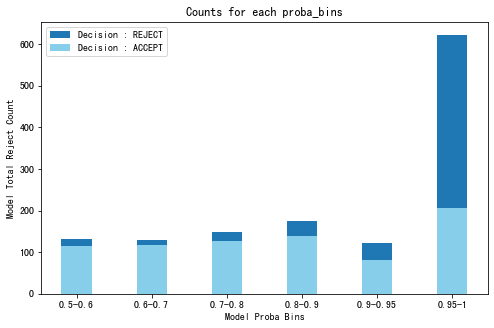

In [57]:
# 统计各区间的数量和 decision 为 1 的数量
counts = result_positive['proba_bins'].value_counts().sort_index()
counts = counts[1:]
decision_counts = result_positive[result_positive['decision'] == 'ACCEPT']['proba_bins'].value_counts().sort_index()
decision_counts = decision_counts[1:]
# 绘制柱状图
fig, ax = plt.subplots(figsize=(8, 5))
x = counts.index
width = 0.4
ax.bar(x, counts, width, label='Decision : REJECT')
ax.bar(x, decision_counts, width, label='Decision : ACCEPT', color='skyblue')
ax.set_xlabel('Model Proba Bins')
ax.set_ylabel('Model Total Reject Count')
ax.set_title('Counts for each proba_bins')
ax.legend()

plt.show()

In [58]:
result_positive[result_positive['decision'] == 'ACCEPT']['proba_bins'].value_counts().sort_index()[5:]

0.9-0.95     81
0.95-1      205
Name: proba_bins, dtype: int64

In [59]:
graph_result = result_positive[result_positive['decision'] == 'ACCEPT']['proba_bins'].value_counts().sort_index()

In [60]:
theshold_list = ["0.5~0.6","0.6~0.7","0.7~0.8","0.8~0.9","0.9~0.95","0.95~1"]

In [61]:
graph_result_pd = pd.DataFrame(graph_result)
graph_result_list = graph_result_pd.proba_bins.tolist()[1:]
graph_result_list

[116, 118, 128, 139, 81, 205]

In [62]:
def calculate_cumulative_sums(lst):
    cumulative_sums = []
    total_sum = sum(lst)
    for number in lst:
        cumulative_sums.append(total_sum)
        total_sum -= number
    return cumulative_sums
result_num = calculate_cumulative_sums(graph_result_list)

In [63]:
theshold_list

['0.5~0.6', '0.6~0.7', '0.7~0.8', '0.8~0.9', '0.9~0.95', '0.95~1']

In [64]:
result_num

[787, 671, 553, 425, 286, 205]

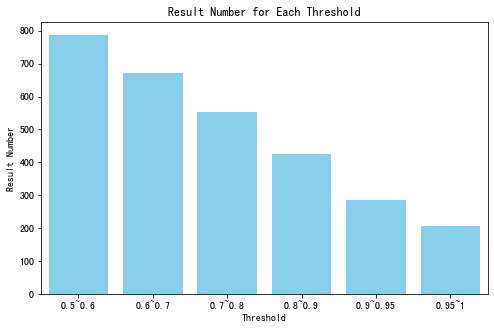

In [65]:
# 绘制柱状图，只显示7个值
plt.figure(figsize=(8, 5))
plt.bar(range(len(theshold_list)), result_num, color='skyblue')
plt.xlabel('Threshold')
plt.ylabel('Result Number')
plt.title('Result Number for Each Threshold')
plt.xticks(range(len(theshold_list)), theshold_list)  # 设置 x 轴刻度及标签
plt.xlim(-0.5, len(theshold_list)-0.5)  # 设置 x 轴的显示范围
plt.show()

In [117]:
save_data = result[result["y_pred"] == 1.0].sample(100).sort_values(by="y_pred_proba").reset_index(drop=True)

In [118]:
# save_data.to_csv("test_20240130.csv")

In [124]:
# save_data

### 人工验证测试

In [10]:
df = pd.read_csv('test_20240130(1).csv')

In [11]:
# 替换数值并查看数量
df['handle_result'] = df['Unnamed: 8'].replace({'有风险': 1, '无风险': 0})
value_counts = df['handle_result'].value_counts()

In [12]:
# df[df["y_pred_proba"]>=0.60]['handle_result'].value_counts()

In [14]:
df = df[["seq_no","pt","decision","y_pred_proba","handle_result"]]

In [16]:
# 替换数值并查看数量
df['decision'] = df['decision'].replace({'REJECT': 1, 'ACCEPT': 0})

In [19]:
df

seq_no        pt  decision  y_pred_proba  \
0   JP202401206649790T001423077305  20240121         0      0.507050   
1   JP202401215607970X002106888786  20240121         0      0.508240   
2   JP202401216607030N001863953351  20240121         0      0.513471   
3   JP202401215970950T001333785737  20240121         1      0.532153   
4   JP202401216996070T001526117646  20240121         0      0.543392   
5   JP2024012168410801002143576947  20240121         0      0.563686   
6   JP202401215321790T001225242030  20240121         1      0.568827   
7   JP202401216539040W001264050464  20240121         0      0.581302   
8   JP202401216642990T001846363646  20240121         1      0.581866   
9   JP2024012163509900001981357467  20240121         0      0.582872   
10  JP202401216645020T001928239149  20240121         1      0.595931   
11  JP202401216912230C001558928371  20240121         1      0.605584   
12  JP202401215585110T001853771404  20240121         1      0.607363   
13  JP2024012064637901001035728755  20240121         0      0.629503   
14  JP202401216397130T001933671555  20240121         1      0.633412   
15  JP202401215697910O001214804971  20240121         0      0.639667   
16  JP2024012171509108001592861564  20240121         1      0.646863   
17  JP202401216272030W002141286272  20240121         0      0.646872   
18  JP202401216465200D001288284167  20240121         1      0.652343   
19  JP202401215671970O001888571616  20240121         0      0.657783   
20  JP202401216734850T001773979665  20240121         1      0.667313   
21  JP202401216368810T001904384579  20240121         1      0.667516   
22  JP2024012166630608001206969119  20240121         0      0.668429   
23  JP202401205932860W001875082250  20240121         0      0.669514   
24  JP202401215922930T001462630295  20240121         0      0.689064   
25  JP2024012166437605001477645573  20240121         1      0.704232   
26  JP202401215401910T001521358221  20240121         1      0.709339   
27  JP202401216422920T001386226302  20240121         1      0.722792   
28  JP2024012173151608001592861564  20240121         1      0.728348   
29  JP20240121654803zw001636239230  20240121         1      0.740328   
30  JP2024012163278608001411377720  20240121         0      0.747502   
31  JP202401216267260T001565182517  20240121         0      0.768563   
32  JP202401217301970C002045071217  20240121         0      0.772619   
33  JP2024012153978101001352667972  20240121         0      0.780015   
34  JP202401216373740O001436889333  20240121         0      0.791735   
35  JP202401215417910T001394921944  20240121         1      0.802958   
36  JP202401216526100T001323514399  20240121         1      0.806385   
37  JP202401216820800V002143516601  20240121         0      0.822381   
38  JP202401216541080J002051296095  20240121         0      0.831655   
39  JP202401215759060W001804862551  20240121         1      0.831791   
40  JP2024012162888508001784256835  20240121         1      0.834000   
41  JP202401215385940Q001761174144  20240121         0      0.839971   
42  JP202401216690190T001897662776  20240121         1      0.842310   
43  JP202401215537860T002143498607  20240121         1      0.846272   
44  JP202401216530140X001988966048  20240121         0      0.873997   
45  JP202401216687010T001958293718  20240121         1      0.878153   
46  JP202401216578960T001323190140  20240121         0      0.888497   
47  JP202401216428020T001720431295  20240121         0      0.892261   
48  JP202401215764120T001801837447  20240121         1      0.898260   
49  JP202401216662910C002143735305  20240121         0      0.903192   
50  JP202401215857900T002088075199  20240121         1      0.907984   
51  JP2024012162411908001918601636  20240121         1      0.909845   
52  JP202401216911030T002134680142  20240121         1      0.910753   
53  JP202401216148960T001719240243  20240121         1      0.917319   
54  JP202401216591800O001821801322  20240121         0      0.921902

In [25]:
from sklearn.metrics import precision_score,recall_score
recall_score = recall_score(df["handle_result"], df["decision"])
print("recall_score:", recall_score)

recall_score: 0.6588235294117647


### 模型上线配参数

In [121]:
['distance_driveraccept_orderstart', 'driver_point_cnt', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_systemclose_paxconfirmgetoncar', 'profit', 'distance_driveraccept_orderend', 'timediff_paxconfirmgetoncar_driveraccept', 'realpay', 'timediff_driveraccept_paxpre', 'distance_paxconfirmgetoncar_orderend', 'timediff_paxconfirmgetoncar_paxpre', 'weekday', 'pax_point_cnt', 'distance_paxpre_orderend', 'driver_order_speed', 'driver_total_ordcnt_7d', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre']

['distance_driveraccept_orderstart',
 'driver_point_cnt',
 'distance_paxpre_orderstart',
 'distance_paxconfirmgetoncar_orderstart',
 'timediff_systemclose_paxconfirmgetoncar',
 'profit',
 'distance_driveraccept_orderend',
 'timediff_paxconfirmgetoncar_driveraccept',
 'realpay',
 'timediff_driveraccept_paxpre',
 'distance_paxconfirmgetoncar_orderend',
 'timediff_paxconfirmgetoncar_paxpre',
 'weekday',
 'pax_point_cnt',
 'distance_paxpre_orderend',
 'driver_order_speed',
 'driver_total_ordcnt_7d',
 'service',
 'hour',
 'timediff_systemclose_driveraccept',
 'total_discount',
 'pax_order_speed',
 'price',
 'driver_paxfirst_ordrate_7d',
 'timediff_systemclose_paxpre']

t.paxdiscount + t.driverdiscount + t.activitydiscount + t.bonus - t.service as profit

In [122]:
### 风控平台现有特征
# distance_driveraccept_orderstart
# distanctimediff_systemclose_paxconfirmgetoncare_paxpre_orderstart
# distance_paxconfirmgetoncar_orderstart
# distance_driveraccept_orderend
# realpay
# distance_paxpre_orderend
# driver_order_speed
# service
# total_discount
# pax_order_speed

In [123]:
### 风控平没用有特征
# driver_point_cnt
# timediff_systemclose_paxconfirmgetoncar
# profit
# timediff_paxconfirmgetoncar_driveraccept
# timediff_driveraccept_paxpre

# distance_paxconfirmgetoncar_orderend

# timediff_paxconfirmgetoncar_paxpre
# weekday
# pax_point_cnt
# driver_total_ordcnt_7d
# hour
# timediff_systemclose_driveraccept
# price
#driver_paxfirst_ordrate_7d
# timediff_systemclose_paxpre

In [139]:
params = {
    "total_discount": "0.0",
    "distance_paxconfirmgetoncar_orderend": "326776.049203",
    "pax_order_speed": "0.708293",
    "driver_order_speed": "1.125451",
    "weekday": "6.000000",
    "timediff_systemclose_paxpre": "575468.000000",
    "driver_paxfirst_ordrate_7d": "null",
    "timediff_paxconfirmgetoncar_driveraccept": "343706.000000",
    "timediff_systemclose_paxconfirmgetoncar": "18460.000000",
    "distance_driveraccept_orderend": "314986.378329",
    "hour": "12.000000",
    "price": "22580.000000",
    "distance_paxconfirmgetoncar_orderstart": "22.104660",
    "profit": "-2290.000000",
    "driver_total_ordcnt_7d": "null",
    "distance_paxpre_orderstart": "128.747856",
    "driver_point_cnt": "247.000000",
    "realpay": "22580.000000",
    "distance_paxpre_orderend": "326809.264639",
    "timediff_paxconfirmgetoncar_paxpre": "557008.000000",
    "service": "2290.000000",
    "timediff_systemclose_driveraccept": "362166.000000",
    "timediff_driveraccept_paxpre": "213302.000000",
    "distance_driveraccept_orderstart": "15905.000844",
    "pax_point_cnt": "3.000000"
}

order = ['distance_driveraccept_orderstart', 'driver_point_cnt', 'distance_paxpre_orderstart', 'distance_paxconfirmgetoncar_orderstart', 'timediff_systemclose_paxconfirmgetoncar', 'profit', 'distance_driveraccept_orderend', 'timediff_paxconfirmgetoncar_driveraccept', 'realpay', 'timediff_driveraccept_paxpre', 'distance_paxconfirmgetoncar_orderend', 'timediff_paxconfirmgetoncar_paxpre', 'weekday', 'pax_point_cnt', 'distance_paxpre_orderend', 'driver_order_speed', 'driver_total_ordcnt_7d', 'service', 'hour', 'timediff_systemclose_driveraccept', 'total_discount', 'pax_order_speed', 'price', 'driver_paxfirst_ordrate_7d', 'timediff_systemclose_paxpre']

processed_params = {key: float(value) if value != "null" else np.nan for key, value in params.items()}
sorted_params = {k: processed_params[k] for k in order if k in processed_params}

In [140]:
df = pd.DataFrame([sorted_params], columns=sorted_params.keys())

In [141]:
df

distance_driveraccept_orderstart  driver_point_cnt  \
0                      15905.000844             247.0   

   distance_paxpre_orderstart  distance_paxconfirmgetoncar_orderstart  \
0                  128.747856                                22.10466   

   timediff_systemclose_paxconfirmgetoncar  profit  \
0                                  18460.0 -2290.0   

   distance_driveraccept_orderend  timediff_paxconfirmgetoncar_driveraccept  \
0                   314986.378329                                  343706.0   

   realpay  timediff_driveraccept_paxpre  \
0  22580.0                      213302.0   

   distance_paxconfirmgetoncar_orderend  timediff_paxconfirmgetoncar_paxpre  \
0                         326776.049203                            557008.0   

   weekday  pax_point_cnt  distance_paxpre_orderend  driver_order_speed  \
0      6.0            3.0             326809.264639            1.125451   

   driver_total_ordcnt_7d  service  hour  timediff_systemclose_driveraccept  \
0                     NaN   2290.0  12.0                           362166.0   

   total_discount  pax_order_speed    price  driver_paxfirst_ordrate_7d  \
0             0.0         0.708293  22580.0                         NaN   

   timediff_systemclose_paxpre  
0                     575468.0

In [142]:
# # 在测试集上评估模型性能
y_pred_info = best_model.predict(df)
y_pred_proba_info = best_model.predict_proba(df)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [148]:
float(y_pred_proba_info[0,1])

2.5603649191907607e-05

In [1]:
5206 + 2603

7809